Imports

In [48]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss

Load the Datasets

In [49]:
# Load the datasets
df_EL = pd.read_csv('./output/EL/results.csv')
df_EP = pd.read_csv('./output/EP/results.csv')
df_L = pd.read_csv('./output/L/results.csv')

# Select the dataset to analyze
data = df_L

# Calculate accuracy
data['accuracy'] = (data['prediction'] == data['label']).astype(int)

Confidence Intervals vs. Accuracy

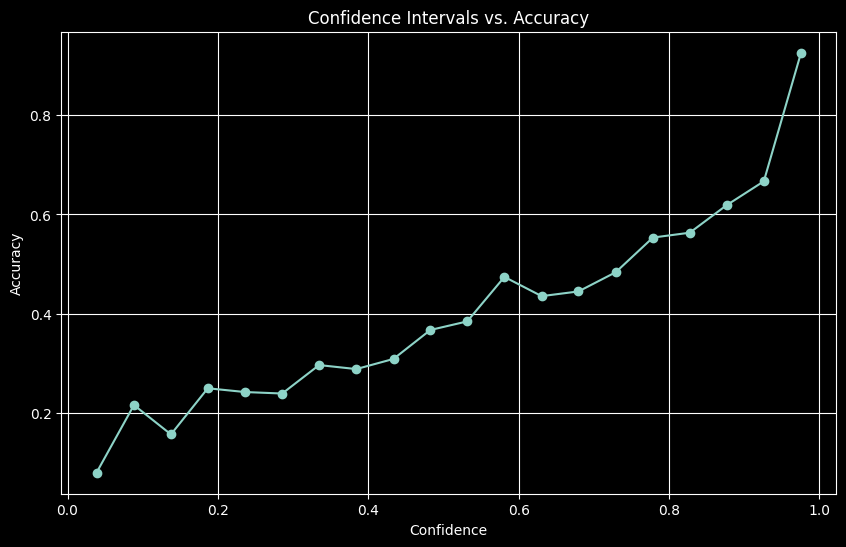

In [50]:
# Define the number of intervals for confidence
num_intervals = 20

# Create confidence intervals
data['confidence_interval'] = pd.cut(data['confidence'], bins=num_intervals)

# Calculate mean accuracy for each interval
interval_accuracy = data.groupby('confidence_interval')['accuracy'].mean().reset_index()

# Calculate the midpoint of each interval for plotting
interval_accuracy['confidence_midpoint'] = interval_accuracy['confidence_interval'].apply(lambda x: x.mid)

# Plot Confidence Intervals vs. Accuracy
plt.figure(figsize=(10, 6))
plt.plot(interval_accuracy['confidence_midpoint'], interval_accuracy['accuracy'], marker='o')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Intervals vs. Accuracy')
plt.grid(True)
plt.show()

Normalized Hyperbolic Radius (in bins) vs. Accuracy

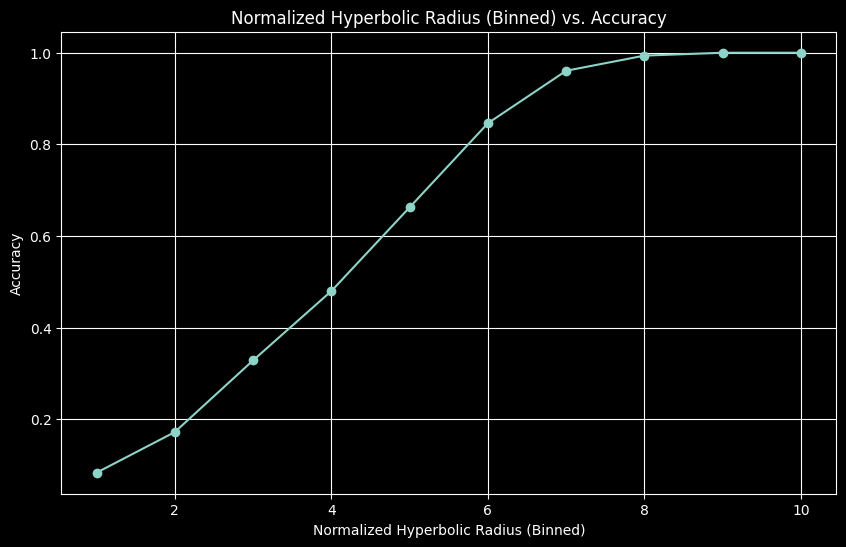

In [51]:
# Bin the normalized hyperbolic radius
bins = np.linspace(data['norm_radius'].min(), data['norm_radius'].max(), 10)
data['norm_radius_binned'] = np.digitize(data['norm_radius'], bins)

# Calculate mean accuracy for each bin
binned_accuracy = data.groupby('norm_radius_binned')['accuracy'].mean().reset_index()

# Plot Normalized Hyperbolic Radius (in bins) vs. Accuracy
plt.figure(figsize=(10, 6))
plt.plot(binned_accuracy['norm_radius_binned'], binned_accuracy['accuracy'], marker='o')
plt.xlabel('Normalized Hyperbolic Radius (Binned)')
plt.ylabel('Accuracy')
plt.title('Normalized Hyperbolic Radius (Binned) vs. Accuracy')
plt.grid(True)
plt.show()

Correlation between Confidence and Hyperbolic Radius

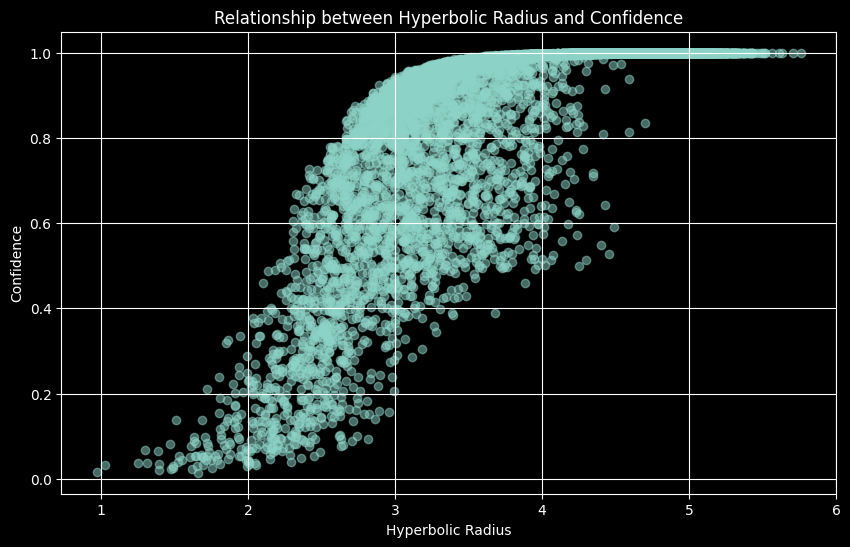

Correlation between Confidence and Hyperbolic Radius: 0.7280309810680777


In [52]:
# Calculate the Pearson correlation coefficient between confidence and hyperbolic radius
correlation = data['confidence'].corr(data['hyper_radius'])

# Plot the relationship between confidence and hyperbolic radius
plt.figure(figsize=(10, 6))
plt.scatter(data['hyper_radius'], data['confidence'], alpha=0.5)
plt.xlabel('Hyperbolic Radius')
plt.ylabel('Confidence')
plt.title('Relationship between Hyperbolic Radius and Confidence')
plt.grid(True)
plt.show()

print('Correlation between Confidence and Hyperbolic Radius:', correlation)


Calibration Plot (Reliability Diagram)

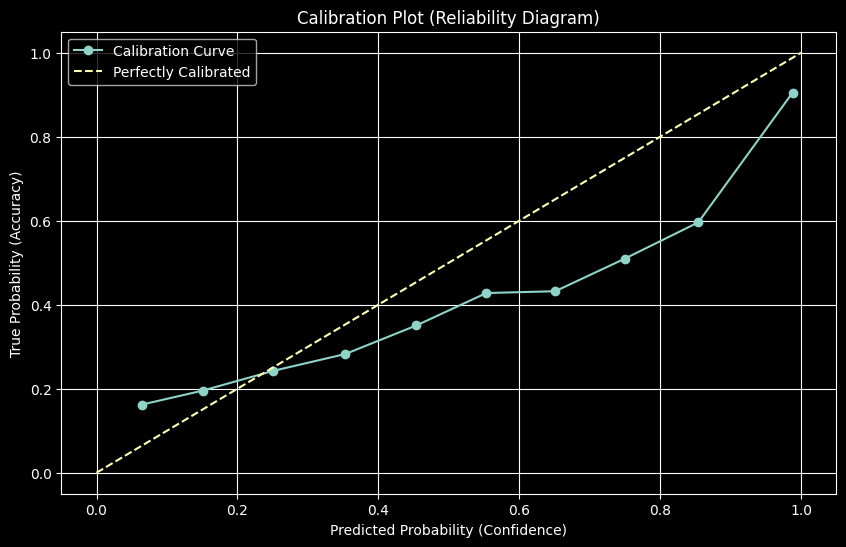

In [53]:
# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(data['accuracy'], data['confidence'], n_bins=10)

# Plot the Calibration Plot (Reliability Diagram)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability (Confidence)')
plt.ylabel('True Probability (Accuracy)')
plt.title('Calibration Plot (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

Calculate ECE and Other Performance Metrics

In [54]:
# Define number of bins for ECE calculation
num_bins = 20

# Create confidence bins
data['confidence_bin'] = pd.cut(data['confidence'], bins=num_bins, labels=False)

# Calculate mean accuracy and confidence for each bin
bin_stats = data.groupby('confidence_bin').agg(
    accuracy=('accuracy', 'mean'),
    avg_confidence=('confidence', 'mean'),
    count=('accuracy', 'count')
).reset_index()

# Calculate the ECE
ece = (bin_stats['count'] * abs(bin_stats['avg_confidence'] - bin_stats['accuracy'])).sum() / bin_stats['count'].sum()

# Calculate other performance metrics
accuracy = data['accuracy'].mean()
precision = precision_score(data['label'], data['prediction'], average='macro')
recall = recall_score(data['label'], data['prediction'], average='macro')
f1 = f1_score(data['label'], data['prediction'], average='macro')
brier_score = brier_score_loss(data['accuracy'], data['confidence'])

# Compile results into a dictionary
metrics = {
    'ECE': ece,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Brier Score': brier_score
}

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Display the DataFrame
metrics_df

,Metric,Value
0,ECE,0.107430
1,Accuracy,0.779000
2,Precision,0.780735
3,Recall,0.779000
4,F1 Score,0.779005
5,Brier Score,0.136362


Temperature Scaling